## Dark frame analyses on NIRcam & 1/f noise, pt. I: data modelling
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Latest update**: Mar 23, 2021

### Introduction

As discussed in Part 1 of this notebook, we are on the lookout for a good model for our data. Here we will try some of them and discuss these results. Let's start by loading some libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# Celerite and PyMultiNest:
import celerite2
from celerite2 import terms
import pymultinest

# Corner for plotting purposes:
import corner

### 1. Modelling read-noise with `celerite`

Let's perform inference on the time-series of amplifier 2 using `celerite`. To this end, we couple `celerite` with `PyMultiNest` in order to optimize the parameters. We first try a stochastically-driven damped harmonic oscillator (SHO) model plus a white-noise term which seems to follow more or less the expected shape of our PSD above (see Figure 1 in the [Foreman-Mackey et al., 2017](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332/meta) paper). 

#### 1.1 Fitting the first group only

For testing purposes, let's first fit the first group of the NIRCam amplifier 2 data. Let's load the data for this group (which we saved in our previous notebook):

In [2]:
x, y = np.load('times_sec_group_0.npy'), np.load('corrected_group_0.npy')
yerr = np.ones(len(y))

Let's compute some stats on this dataset:

In [3]:
print(x.shape)
tmin, tmax = np.min(np.abs(np.diff(x))), np.max(x) - np.min(x)
ymin, ymax = np.min(y), np.max(y)
print('Min and max time-scales:', tmin, tmax)
print('Min and max counts:', ymin, ymax)

(1046199,)
Min and max time-scales: 9.999999999621423e-06 10.73139
Min and max counts: -55.24384880065918 57.76782035827637


Note this is a _huge_ dataset (haven't used `celerite` with such big datasets before!). 

All right, let's initialize the celerite model. We'll use the SHO model parametrization that constrains it using three parameters that make intuitive sense: 

1. The **standard deviation of the process, $\sigma_{GP}$**, which we know is bounded from above as we know the overall fluctuation of the dataset (see Min and max counts above).

2. The **undamped period of the oscillator, $\rho$**, which sets a typical time-scale for the problem. Given our time-scales are also bounded (see Min amd max time-scales, above), this parameter is also bounded.

3. The **quality factor of the damped harmonic oscillator, $Q$** which, given this is a non-periodic process, we know it will be smaller than about 2 (see Figure 1 in [Foreman-Mackey et al., 2017](https://iopscience.iop.org/article/10.3847/1538-3881/aa9332/meta)).


In [4]:
kernel = terms.SHOTerm(sigma=1.0, rho=0.1, Q = 2.)
gp = celerite2.GaussianProcess(kernel, mean=0.)

Let's now define the prior transforms we will be using (this is Nested Sampling jargon, but basically, Nested Samplers sample in the unit cube --- so to sample with arbitrary distributions, we have to transform those samples to suit our needs). We'll be using uniform and log-uniform priors:

In [5]:
def transform_uniform(x,a,b):
    return a + (b-a)*x

def transform_loguniform(x,a,b):
    la=np.log(a)
    lb=np.log(b)
    return np.exp(la + x*(lb-la))

Now define the prior and the likelihood. We will be fitting for four terms. The first three terms will be defining the SHO itself: the standard deviation of the process, $\sigma_{GP}$, the undamped period of the oscillator, $\rho$ and the damping time-scale of the process, $\tau$ (see the `SHOTerm` definition in `celerite` [here](https://celerite2.readthedocs.io/en/latest/api/python/#python-recommended)). The fourth term is a white-noise component, $\sigma_w$ --- so we will be modelling our process as a SHO on top of white-noise:

In [6]:
def prior(cube, ndim, nparams):
    # Prior on sigma_w in units of counts; note the upper limit is 100, 
    # which is the overal amplitude of the dataset itself (see Min and max counts above):
    cube[0] = transform_loguniform(cube[0], 1., 100.)
    # Prior on sigma_GP, rho and tau:
    # sigma_GP covers same ground as sigma_w:
    cube[1] = transform_loguniform(cube[1], 1., 100.)
    # Prior on rho, covering all relevant time-scales:
    cube[2] = transform_loguniform(cube[2], tmin, tmax)
    # Uniform prior on Q; smaller than 2, larger than 0:
    cube[3] = transform_uniform(cube[3], 0., 2.)
    
def loglike(cube, ndim, nparams):
    # Extract parameters
    sigma_w, sigma_gp, rho, Q = cube[0], cube[1], cube[2], cube[3]
    # Assume zero-mean process:
    gp.mean = 0.
    # Set GP kernel, compute with diagonal errors:
    gp.kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho, Q = Q)
    gp.compute(x, diag=(yerr*sigma_w)**2, quiet=True)
    # Return log-likelihood
    return gp.log_likelihood(y)

It is important to note, before moving forward, that the underlying assumption behind this log-likelihood is that the data is _normally distributed_. This is, of course, only an approximation --- we _know_ the underlying process is Poisson (at the very least the white-noise part of it). Good news is that for rates as small as 3-4 the Gaussian approximation is actually pretty good (but this nonetheless should be kept in mind). 

All right, now let's fit this (beware --- this takes _a while_; about ten minutes on my laptop)!

In [7]:
n_params = 4
pymultinest.run(loglike, prior, n_params, n_live_points = 100, \
                outputfiles_basename='one_group_fit', resume = False, verbose = True)

Let's extract the posterior parameter distributions:

In [8]:
# Get output, weight posteriors:
output = pymultinest.Analyzer(outputfiles_basename='one_group_fit', n_params = n_params)
posterior_samples = output.get_equal_weighted_posterior()[:,:-1]

# Get posterior samples:
sigma_w_samples = posterior_samples[:,0]
sigma_gp_samples = posterior_samples[:,1]
rho_samples = posterior_samples[:,2]
Q_samples = posterior_samples[:,3]

  analysing data from one_group_fit.txt


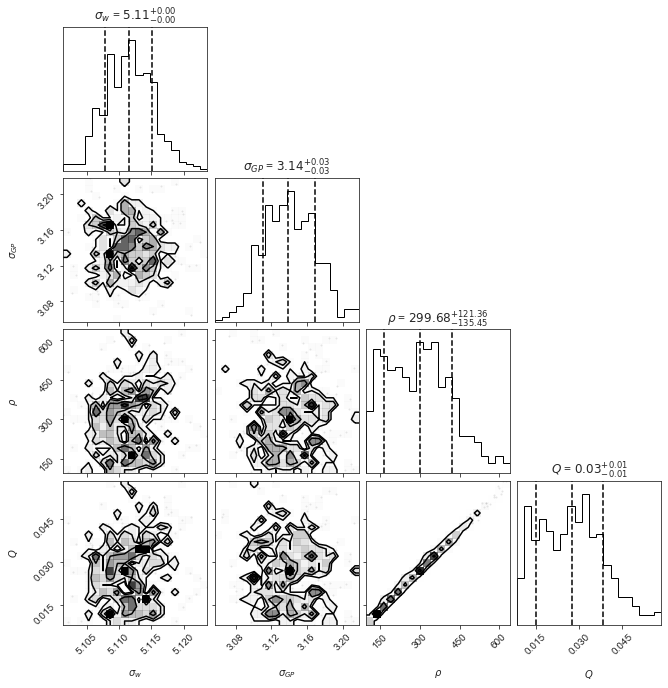

In [9]:
# Before plotting it, transform rho to micro-seconds --- which is a better time-scale for plotting this process:
ps = np.copy(posterior_samples)
ps[:,2] = ps[:,2]*1e6

# Plot it:
figure = corner.corner(ps, labels=[r"$\sigma_w$", r"$\sigma_{GP}$", r"$\rho$", r"$Q$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

All right! It seems $Q$ and $\rho$ are very correlated with each other. We'll talk more about this below, but first, let's plot a section of the time-series to see how well we did with our GP:

Text(0.5, 1.0, 'Posterior GP prediction (conditioned on data)')

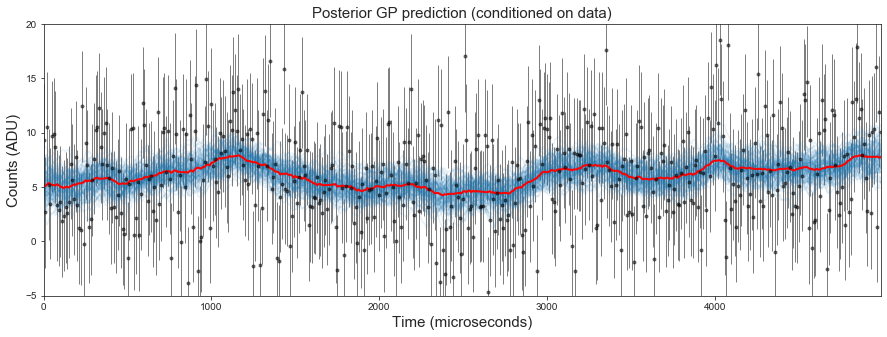

In [48]:
# Plot time-series:
idx = np.where(x<5*1e-3)[0]
plt.figure(figsize=(15,5))
plt.errorbar(x[idx]*1e6, y[idx], yerr=yerr[idx]*np.median(sigma_w_samples),fmt='.', \
             alpha=0.5, elinewidth=1, color='black')

# Plot some sample predictions from GP on top:
first_time = True
for sample in posterior_samples[np.random.randint(posterior_samples.shape[0], size=100)]:
    # Extract sample:
    sigma_w, sigma_gp, rho, Q = sample
    # Compute GP:
    gp.kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho, Q = Q)
    gp.compute(x[idx], diag=(yerr[idx]*sigma_w)**2, quiet=True)
    # Condition GP on data:
    conditional = gp.condition(y[idx], x[idx])
    # Plot sample:
    sample = conditional.sample()
    plt.plot(x[idx]*1e6, sample, color="C0", alpha=0.1)
    if first_time:
        all_samples = np.copy(sample)
        first_time = False
    else:
        all_samples = np.vstack((all_samples, np.copy(sample)))
        
# Plot median of all model samples as the median model:
plt.plot(x[idx]*1e6, np.median(all_samples, axis = 0), color="red", lw = 2)

# Set labels:
plt.xlim(np.min(x[idx])*1e6,np.max(x[idx])*1e6)
plt.ylim(-5,20)
plt.xlabel('Time (microseconds)', fontsize=15)
plt.ylabel('Counts (ADU)', fontsize=15)
plt.title('Posterior GP prediction (conditioned on data)', fontsize=15)

In [53]:
gp.compute(x, diag=(yerr*sigma_w)**2, quiet=True)

In [54]:
conditional = gp.condition(y, x)

In [ ]:
dd = conditional.sample()

What about the power-spectral density shape? In principle, `celerite` has some functionality to generate thoseis that this has a nice convenience function to plot the PSD of a given process given the parameters. There's 

In [50]:
freq = np.linspace(1./5.,1./2e-5,65536)

# Celerite likes to play with angular frequencies. That's OK:
omega = 2 * np.pi * freq

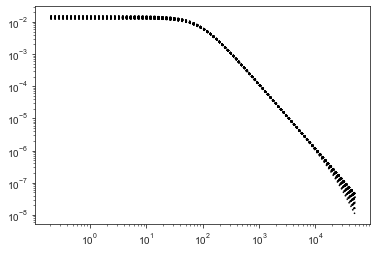

In [52]:
first_time = True
for sample in posterior_samples[np.random.randint(posterior_samples.shape[0], size=100)]:
    # Extract sample:
    sigma_w, sigma_gp, rho, Q = sample
    # Compute GP:
    gp.kernel = terms.SHOTerm(sigma=sigma_gp, rho=rho, Q = Q)
    # Plot PSD:
    psd = gp.kernel.get_psd(omega)
    plt.loglog(freq, psd, ":k", label="full model")
    if first_time:
        all_psds = np.copy(psd)
        first_time = False
    else:
        all_psds = np.vstack((all_psds, np.copy(psd)))